Title: Predicting BTC Closing Value Based on Past 30 days of Data

Authors: Mike Limpus, Michael Hackett, Katie Vickstrom, Josh Hansen

Intro: Given the volatility of the crypto market lately, we are interested in seeing if we can predict Bitcoin prices based on the historical and recent history of Bitcoin prices. We want to predict the next closing price based on the average open, high, low, and volume of the past 30 days.

Choice of dataset: We downloaded a csv from https://www.investing.com/crypto/bitcoin/historical-data where chose the timeframe of Bitcoin historical data from 6/4/2020-6/4/2022. This was then uploaded to Github as there is no direct link: https://raw.githubusercontent.com/KatherineVickstrom/DataScience/main/Bitcoin_Historical%20Data_%20Investing_com_20200604_20220604.csv

Target to predict: 'Price' - the closing price of Bitcoin stocks at the end of the day.

Predictors: Average 'Open', 'Low', 'High', and 'Vol' of the past 30 days

Preparation: We first import the CSV from Github to a dataframe:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import zscore

df = pd.read_csv(r'https://raw.githubusercontent.com/KatherineVickstrom/DataScience/main/Bitcoin_Historical%20Data_%20Investing_com_20200604_20220604.csv', thousands=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      731 non-null    object 
 1   Price     731 non-null    float64
 2   Open      731 non-null    float64
 3   High      731 non-null    float64
 4   Low       731 non-null    float64
 5   Vol.      731 non-null    object 
 6   Change %  731 non-null    object 
dtypes: float64(4), object(3)
memory usage: 40.1+ KB


Since we are interested in the closing prices, we set them aside as our target. We determined that the time series data is not a valid predictor so we drop the date and change percentage columns:

In [2]:
target = df['Price']
df.drop(['Date','Change %','Price'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    731 non-null    float64
 1   High    731 non-null    float64
 2   Low     731 non-null    float64
 3   Vol.    731 non-null    object 
dtypes: float64(3), object(1)
memory usage: 23.0+ KB


Convert volume column:

In [3]:
def volume_convert(x):
    # Last character is K, M, or B
    a = x[-1]
    b = float(x[:-1])
    if a == 'K':
        return b * 1e3
    elif a == 'M':
        return b * 1e6
    else:
        return b * 1e9

df['Vol.'] = df['Vol.'].apply(volume_convert)

We transform our raw values into a feature list of past 30-day averages ('Open', 'High', 'Low', and 'Vol') for each target value, and we ensure the number of targets equals the number of samples. We are stripping away the concept of a time series from this data set by ensuring that each sample is independent. This is accomplished by transforming the Open, High, Low, and Vol. values in each row into averages of the previous 30 rows (days).

In [4]:
days_prior = 30 # 30-day "snapshots"
last_row = df.shape[0] - days_prior # No more 30-day periods after this point

# Creates a list of 30-day averages (4-tuples) using raw 'Open', 'High', 'Low', and 'Vol.' column values
averages = []
for i in range(last_row):
    averages.append(df.iloc[i:i+days_prior].mean())

# Create new dataframe using extracted averages
df = pd.DataFrame(averages)
df.rename(columns={'Open':'Open_Avg_30_Day', 
                   'High': 'High_Avg_30_Day', 
                   'Low':'Low_Avg_30_Day', 
                   'Vol.':'Vol_Avg_30_Day'}, inplace=True)

# Drop extraneous targets (ensure #targets = #samples)
indexes = np.arange(last_row, len(target))
target.drop(index=indexes, inplace=True)

# Drop samples with volume outliers (greater than 3 standard deviations)
indexes = df[(zscore(df['Vol_Avg_30_Day']) > 3)].index
df.drop(index=indexes, inplace=True)
target.drop(index=indexes, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 674 entries, 0 to 700
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open_Avg_30_Day  674 non-null    float64
 1   High_Avg_30_Day  674 non-null    float64
 2   Low_Avg_30_Day   674 non-null    float64
 3   Vol_Avg_30_Day   674 non-null    float64
dtypes: float64(4)
memory usage: 26.3 KB


We describe our features:

Text(0.5, 1.0, '30-day Avgs. for Open, High, and Low (2-Year Period)')

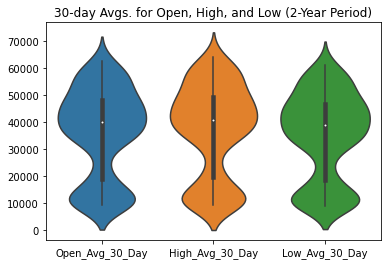

In [5]:
ax = sns.violinplot(data=df[['Open_Avg_30_Day','High_Avg_30_Day', 'Low_Avg_30_Day']])
ax.set_title("30-day Avgs. for Open, High, and Low (2-Year Period)")

Text(0.5, 1.0, '30-day Avgs. for Volume (2-Year Period)')

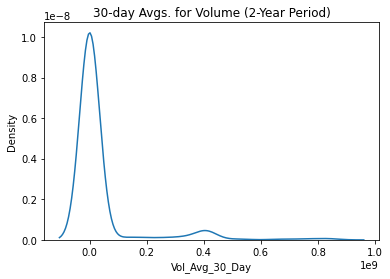

In [6]:
ax = sns.kdeplot(df['Vol_Avg_30_Day'])
ax.set_title("30-day Avgs. for Volume (2-Year Period)")

We view the distribution of closing prices in our dataset (our target values):

[Text(0.5, 0, 'Closing Prices')]

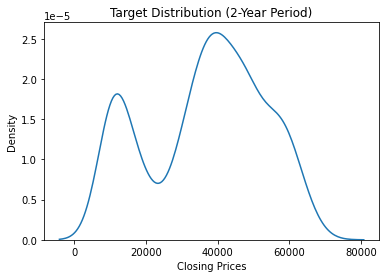

In [7]:
ax = sns.kdeplot(target)
ax.set_title("Target Distribution (2-Year Period)")
ax.set(xlabel="Closing Prices")

A correlation heatmap indicates some of our predictors are highly correlated and can possibly be eliminated:

<AxesSubplot:>

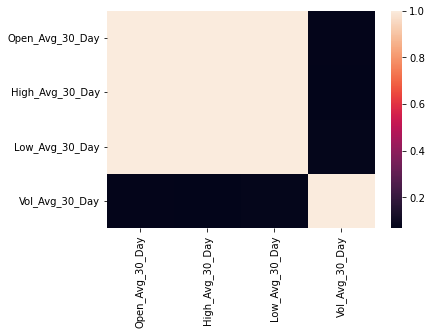

In [8]:
sns.heatmap(df.corr())

We create training and test sets, using 80% and 20% of our data, respectively. We are still using a randomization to the sorting of test and train sets because we no longer consider rows in correlation to the rows immediately surrounding, as each row in the predictor set is the average of the last 30 days when the set was considered a time series previously.

In [9]:
X = df.values # features as NumPy
y = target.values # targets as NumPy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We will show the effects of a scaler on our training features.

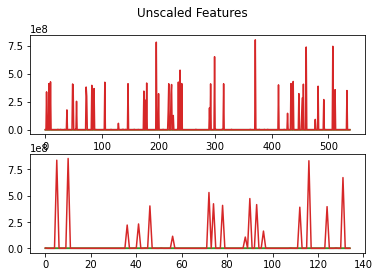

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

fig, axes = plt.subplots(2)
fig.suptitle("Unscaled Features")
axes[0].plot(X_train)
axes[1].plot(X_test)

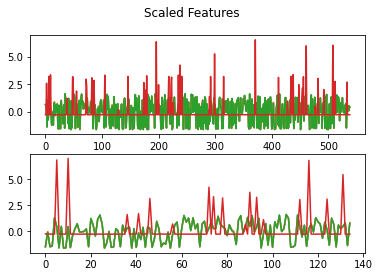

In [11]:
fig, axes = plt.subplots(2)
fig.suptitle("Scaled Features")
axes[0].plot(X_train_scaled)
axes[1].plot(X_test_scaled)

We can see that the data is being properly scaled down, with a mean of 0 and standard deviation of 1.



---



Our baseline model is Lasso, a variation of linear regression which implicitly eliminates unnecessary features. For reference, we compute Lasso's cross-validation score on our entire data set. Note that Lasso uses R² scoring:

In [12]:
lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X, y)
print(f'Baseline score: {lasso_cv.score(X,y).round(3)}')

Baseline score: 0.914


We compare the cross-validation technique with a standard Lasso Regression model. For the model to converge successfully, scaled features with an alpha of 75 are used:

In [13]:
# Higher alphas result in more features being removed from the model
lasso = Lasso(alpha=75.0)
lasso.fit(X_train_scaled, y_train)

print(f'Training score: {lasso.score(X_train_scaled, y_train).round(3)}')
print(f'Test score: {lasso.score(X_test_scaled,y_test).round(3)}')

Training score: 0.915
Test score: 0.907


The scores are similar to our baseline score. Here we visualize our predicted versus actual values:

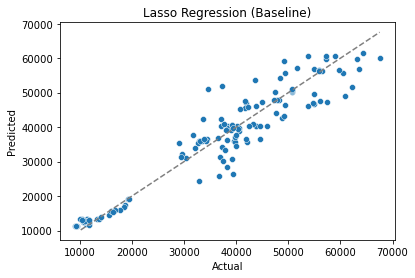

In [14]:
def predicted_vs_actual(actual, predicted, title):
  a = (actual.min()+predicted.min())/2
  b = (actual.max()+actual.max())/2
  # To get rid of warning
  temp = pd.DataFrame(actual, columns=['actual'])
  temp['predicted'] = pd.DataFrame(predicted)
  ax = sns.scatterplot(x='actual', y='predicted', data=temp)
  ax.set_xlabel("Actual")
  ax.set_ylabel("Predicted")
  ax.set_title(title)
  plt.plot([a,b],[a,b],color='grey',linestyle='dashed')

predicted_vs_actual(y_test, lasso.predict(X_test_scaled), "Lasso Regression (Baseline)")

As a comparison to our baseline model, we have chosen Linear Regression. Here are the R² and RMSE scores for our test data:

In [15]:
reg=LinearRegression()
reg.fit(X_train_scaled, y_train)
r1 = reg.score(X_test_scaled, y_test)
predictions = reg.predict(X_test_scaled)
rmse = np.sqrt(((predictions - y_test)**2).mean())
print('R-squared: {:.3f}'.format(r1))
print('RMSE: {0:.0f}'.format(rmse))

R-squared: 0.976
RMSE: 2476


A visual of our predicted versus actual values for Linear Regression with all features.

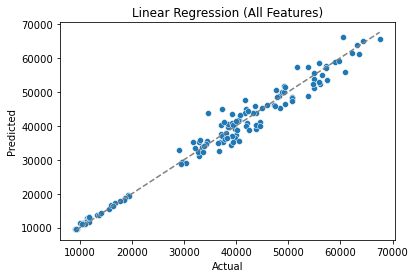

In [16]:
predicted_vs_actual(y_test, predictions, "Linear Regression (All Features)")

Now if we remove volume from the feature set and run again, we can see whether or not this is a noise feature by checking the training and test scores once more with Linear Regression:

In [17]:
df1 = df.drop(columns=['Vol_Avg_30_Day'])

X = df1.values # features as NumPy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

reg=LinearRegression()
reg.fit(X_test_scaled, y_test)
r1 = reg.score(X_test_scaled, y_test)
predictions = reg.predict(X_test_scaled)
rmse = np.sqrt(((predictions - y_test)**2).mean())
print('R-squared : {:.3f}'.format(r1))
print('RMSE: {0:.0f}'.format(rmse))

R-squared : 0.974
RMSE: 2583


We can see that removing the volume predictor leads to a slightly worse prediction.

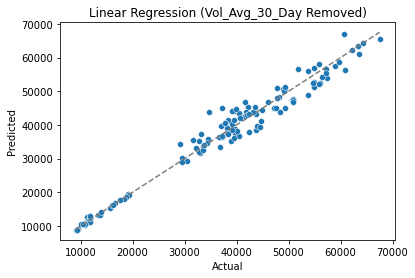

In [18]:
predicted_vs_actual(y_test, predictions, "Linear Regression (Vol_Avg_30_Day Removed)")